# Projet : Prédiction de la consommation énergétique des appareils électroménagers

Ce notebook a été réalisé dans le cadre du projet de fin de semestre du cours **d’Apprentissage Statistique**. Il vise à mettre en œuvre, sur un cas concret, les notions étudiées pendant le semestre, notamment autour de la régression supervisée.

**Binôme :** Issa KA (<issa.ka@etu.sorbonne-universite.fr>) & Clara Garcia Pérez (<clara.garcia_perez@etu.sorbonne-universite.fr>)  
**Date de rendu :** 30 avril 2025  


# 1. Contexte et objectif

L’objectif de ce projet est de développer un **notebook Python** illustrant :

- La **lecture** et l’**analyse exploratoire** d’un jeu de données réelles ;
- La **mise en place** et la **comparaison** de plusieurs méthodes de régression (linéaire, Ridge, réseau de neurones dense) ;
- La **compréhension** de l’impact des **hyperparamètres** et des **choix de pré‑traitement** sur les performances.

**Données** :  
- Source : UCI ML – Energy Efficiency Data Set  
  https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv  
- Objectif : prédire `Appliances` (Wh) toutes les 10 minutes à partir de mesures ambiantes (températures, humidités, météo, lumière…).


<br>**Référence** :  
> - Candanedo et al., *Data driven prediction models of energy use of appliances in a low-energy house*, *Energy & Buildings* 2017  

In [1]:
# Versions 
import sys
print("Python   :", sys.version.splitlines()[0])
print("Pandas   :", __import__("pandas").__version__)
print("NumPy    :", __import__("numpy").__version__)
print("scikit‑learn:", __import__("sklearn").__version__)
print("Pytorch  :", __import__("torch").__version__)

Python   : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
Pandas   : 2.2.2
NumPy    : 1.26.4
scikit‑learn: 1.5.1
Pytorch  : 2.6.0.dev20241108


# 2. Chargement et premier aperçu 

In [2]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils as ut
import importlib
importlib.reload(ut)

<module 'utils' from 'c:\\Users\\cheri\\nsi\\M1\\energy_consumption_prediction\\utils.py'>

In [3]:
# Load the dataset
df = pd.read_csv(
    "energydata_complete.csv",
    parse_dates=["date"],     # convert date column to datetime
    index_col="date"          # set date as index
)

In [4]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [5]:
print("Informations sur le DataFrame :\n")
df.info()

Informations sur le DataFrame :

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 n

In [6]:
print(f"Dimensions : {df.shape[0]} lignes et {df.shape[1]} colonnes")

Dimensions : 19735 lignes et 28 colonnes


**Premier aperçu** :
- **Granularité temporelle** : 10 minutes.  
- **Période couverte** : ~137 jours donc 4 mois (janvier–mai 2016).  
- **Nombre d’observations** : 19 735 
- **valeurs manquantes** : 0
- **Nombre de variables** :  
  - 1 cible : `Appliances` (Wh)  
  - 1 variable temporelle : `date` (timestamp)
  - 27 variables explicatives (temperatures, humidités, météo…)  

# 3. Analyse descriptive

Avant toute analyse, on commence par **supprimer** les deux variables aléatoires créées pour le filtrage (`rv1`, `rv2`), qui n’apportent rien à l’exploration.

In [7]:
# Delete the columns 'rv1' and 'rv2' as they are not needed for the analysis
df = df.drop(columns=['rv1', 'rv2'])

In [8]:
# new shape after dropping columns
df.shape

(19735, 26)

On a maintenant 25 **variables explicatives** 

**Description des variables** :

| Variable       | Description                                                      | Unité   |
|----------------|------------------------------------------------------------------|---------|
| **date**       | Date et heure (AAAA‑MM‑JJ HH:MM:SS)                              | –       |
| **Appliances** | Consommation énergétique des appareils ménagers                  | Wh      |
| **lights**     | Consommation énergétique de l’éclairage                          | Wh      |
| **T1**         | Température dans la cuisine                                      | °C      |
| **RH_1**       | Humidité relative dans la cuisine                                | %       |
| **T2**         | Température dans le salon                                        | °C      |
| **RH_2**       | Humidité relative dans le salon                                  | %       |
| **T3**         | Température dans la buanderie                                    | °C      |
| **RH_3**       | Humidité relative dans la buanderie                              | %       |
| **T4**         | Température dans le bureau                                       | °C      |
| **RH_4**       | Humidité relative dans le bureau                                 | %       |
| **T5**         | Température dans la salle de bain                                | °C      |
| **RH_5**       | Humidité relative dans la salle de bain                          | %       |
| **T6**         | Température extérieure (côté nord du bâtiment)                   | °C      |
| **RH_6**       | Humidité relative extérieure (côté nord du bâtiment)             | %       |
| **T7**         | Température dans la pièce de repassage                           | °C      |
| **RH_7**       | Humidité relative dans la pièce de repassage                     | %       |
| **T8**         | Température dans la chambre adolescente 2                         | °C      |
| **RH_8**       | Humidité relative dans la chambre adolescente 2                   | %       |
| **T9**         | Température dans la chambre des parents                          | °C      |
| **RH_9**       | Humidité relative dans la chambre des parents                    | %       |
| **T_out**      | Température extérieure (aéroport à proximité)                    | °C      |
| **Press_mm_hg**| Pression atmosphérique                                           | mm Hg   |
| **RH_out**     | Humidité relative extérieure                                     | %       |
| **Windspeed**  | Vitesse du vent                                                  | m/s     |
| **Visibility** | Visibilité                                                       | km      |
| **Tdewpoint**  | Température du point de rosée                                    | °C      |

## 3.1 Statistiques descriptives globales

In [9]:
stats = df.describe().T.round(2) # Transpose the summary and round the values to 2 decimal places
stats

,count,mean,std,min,25%,50%,75%,max
Appliances,19735.0,97.69,102.52,10.00,50.00,60.00,100.00,1080.00
lights,19735.0,3.80,7.94,0.00,0.00,0.00,0.00,70.00
T1,19735.0,21.69,1.61,16.79,20.76,21.60,22.60,26.26
RH_1,19735.0,40.26,3.98,27.02,37.33,39.66,43.07,63.36
T2,19735.0,20.34,2.19,16.10,18.79,20.00,21.50,29.86
RH_2,19735.0,40.42,4.07,20.46,37.90,40.50,43.26,56.03
T3,19735.0,22.27,2.01,17.20,20.79,22.10,23.29,29.24
RH_3,19735.0,39.24,3.25,28.77,36.90,38.53,41.76,50.16
T4,19735.0,20.86,2.04,15.10,19.53,20.67,22.10,26.20
RH_4,19735.0,39.03,4.34,27.66,35.53,38.40,42.16,51.09


**Interprétation des statistiques globales**
1. **Variable cible `Appliances`**  
   - **Moyenne** ≃ 98 Wh, **écart‑type** ≃ 102 Wh : forte dispersion, signe d’alternance entre périodes calmes et pointes de consommation.  
   - **Minimum** à 10 Wh, **maximum** à 1080 Wh : présence de valeurs extrêmes (pics de consommation) qui pourraient influencer la modélisation.

2. **Éclairage `lights`**  
   - Moyenne faible (≈ 3.8 Wh), très souvent nulle (**médiane** 0, **75 %** des observations à 0) avec quelques pointes jusqu’à 70 Wh : usage occasionnel, potentiellement indicateur d’occupation.

3. **Températures intérieures (`T1` à `T5`, `T7` à `T9`)**  
   - Globalement comprises entre 15 et 30 °C, **moyennes** entre 19 et 22 °C, avec une faible variabilité (écart‑type ≃ 1.5 à 2.5 °C).  
   - Indique un bon niveau d’isolation et un contrôle thermique efficace à l’intérieur.

4. **Humidité relative intérieure (`RH_1` à `RH_5`, `RH_7` à `RH_9`)**  
   - Moyennes généralement entre 35 % et 50 %, sauf en salle de bain (`RH_5`) où l’humidité peut monter à 96 %.  
   - Des pics d’humidité dans certaines pièces peuvent signaler l’usage intensif de douches, machines ou autres appareils électroménager.

5. **Indicateurs extérieurs**  
   - **T6** (température nord du bâtiment) : moyenne ≃ 7.9 °C, varie de −6 °C à +28 °C ; **RH_6** : moyenne ≃ 54.6 %, de 1 % à 99.9 %.  
   - **T_out** (météo aéroport) : moyenne ≃ 7.4 °C, de −5 °C à +26 °C.  
   - Vent modéré (moyenne ≃ 4 m/s, max 14 m/s), visibilité majoritairement élevée (> 40 km), pression stable autour de 755 mm Hg.

> Ces premières statistiques révèlent une **forte hétérogénéité** de la consommation `Appliances`, des **conditions intérieures relativement stables** et des **indicateurs extérieurs** plus variables. Nous allons poursuivre ces analyse pour prendre en compte ces éléments dans la modélisation.

## 3.2 Analyse de la cible `Appliances`

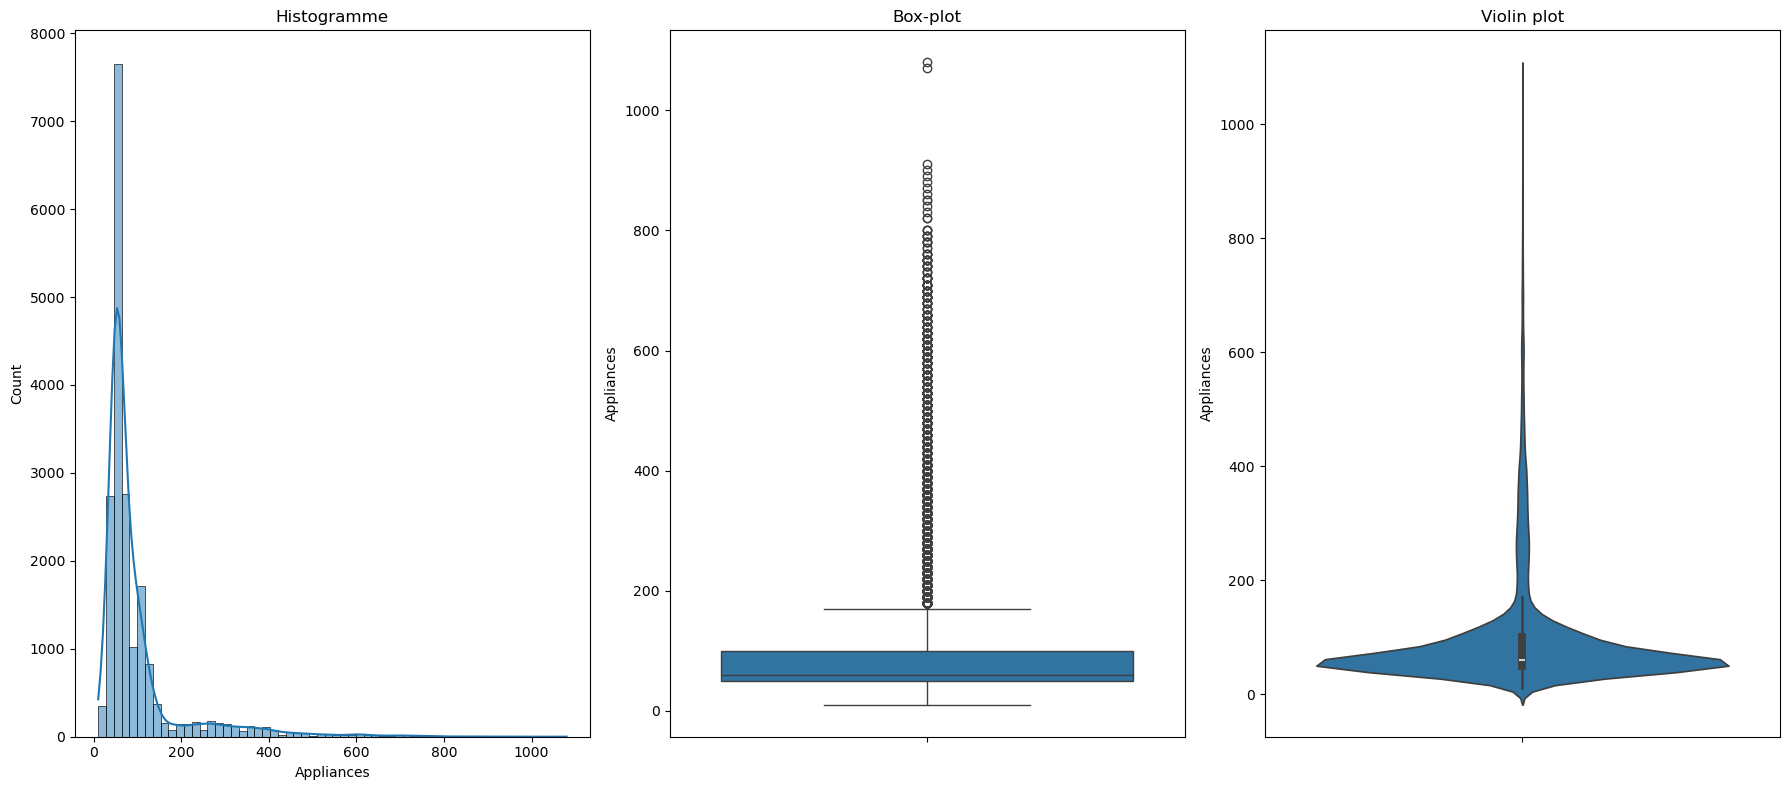

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Histogram
sns.histplot(df['Appliances'], bins=60, kde=True, ax=axes[0])
axes[0].set_title("Histogramme")

# Boxplot
sns.boxplot(y=df['Appliances'], ax=axes[1])
axes[1].set_title("Box‑plot")

# Violin plot
sns.violinplot(y=df['Appliances'], ax=axes[2])
axes[2].set_title("Violin plot")

plt.tight_layout()
plt.show()


Cela confirme et précise les conclusions précédentes sur la consommation `Appliances` :
- **Distribution très asymétrique**  
  - La majorité des valeurs se concentre entre 10 Wh et 150 Wh (histogramme), avec une longue queue à droite jusqu’à ≃ 1 080 Wh.  
  - La **médiane** (~ 60 Wh) est inférieure à la **moyenne** (~ 98 Wh) : les rares pointes élevées tirent la moyenne vers le haut.

- **Outliers marqués**  
  - Le box‑plot montre de nombreux points au‑dessus du 75ᵉ quantile (~ 100 Wh) et des valeurs extrêmes autour de 800–1 000 Wh.  
  - Ces pointes peuvent correspondre à des appareils gros consommateurs (lave‑linge, four), des périodes de forte occupation ou des erreurs de mesure.


On créé des variables catégorielles temporelles pour mieux comprendre la consommation `Appliances` :
- `dayofweek` : jour de la semaine (0 = lundi, 6 = dimanche)
- `hour` : heure de la journée (0–23)

On envisage aussi de les utiliser comme variables explicatives dans la modélisation. 

In [11]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek  # 0 = lundi…6 = dimanche


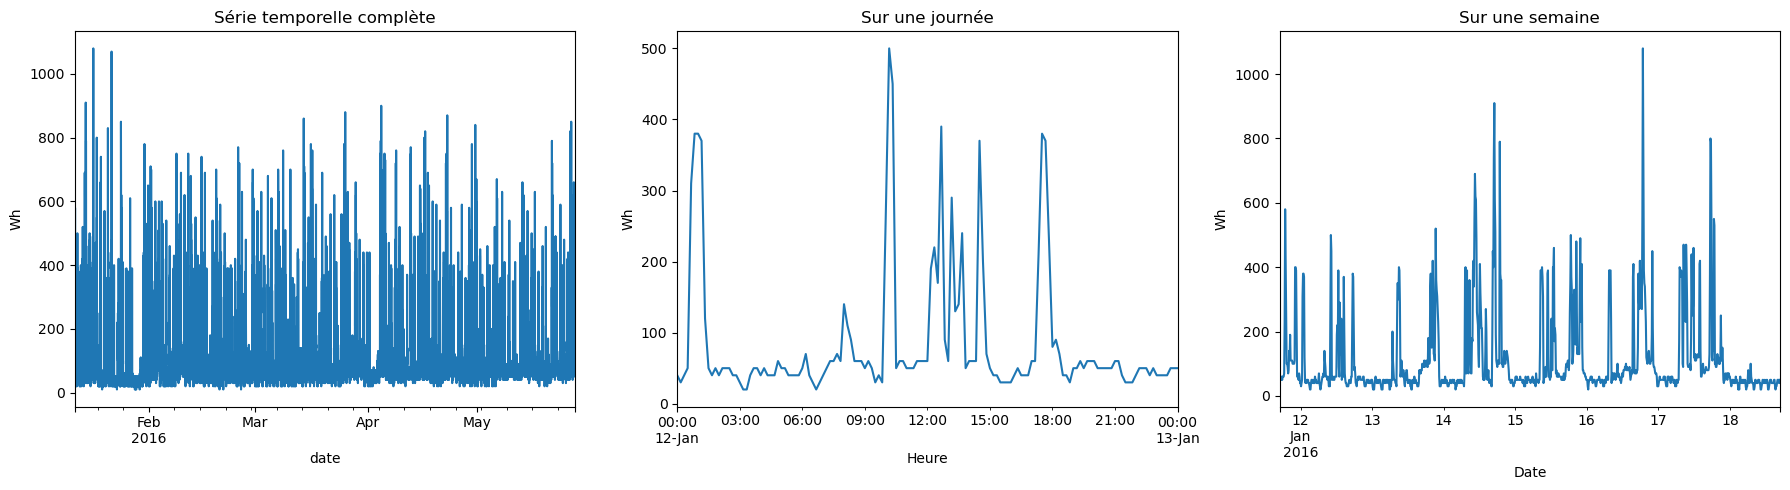

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# time series on the complete dataset
df['Appliances'].plot(ax=axes[0])
axes[0].set_title("Série temporelle complète")
axes[0].set_ylabel("Wh")

# time series on a day (first day of the dataset)
jour = df.loc[df.index[0]+ pd.Timedelta(hours=7):df.index[0] + pd.Timedelta(hours=7) + pd.Timedelta(days=1)] # because the first day starts at 17h
jour['Appliances'].plot(ax=axes[1])
axes[1].set_title("Sur une journée")
axes[1].set_xlabel("Heure")
axes[1].set_ylabel("Wh")

# time series on a week (first week of the dataset)
premiere_semaine = df.loc[(df.index >= df.index[0]) & (df.index < df.index[0] + pd.Timedelta(days=7))]
premiere_semaine['Appliances'].plot(ax=axes[2])
axes[2].set_title("Sur une semaine")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Wh")

plt.tight_layout()
plt.show()

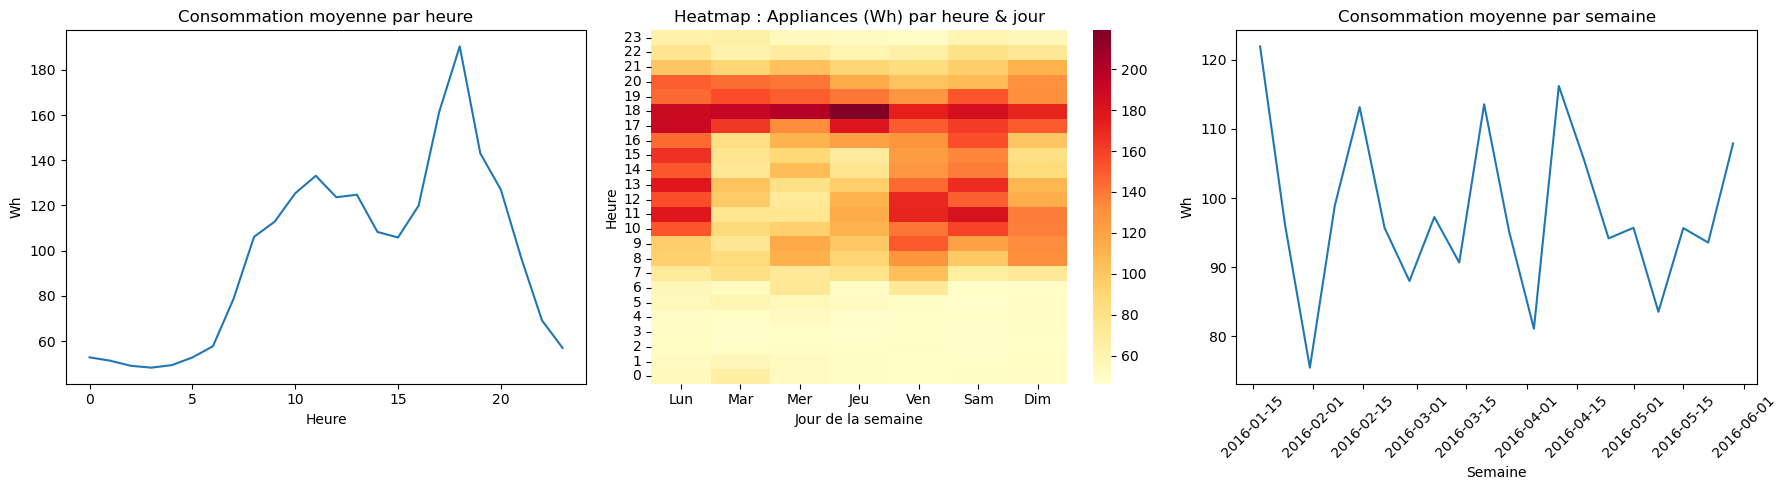

In [13]:
hourly = df.groupby('hour')['Appliances'].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# average consumption per hour
sns.lineplot(x=hourly.index, y=hourly.values, ax=axes[0])
axes[0].set_title("Consommation moyenne par heure")
axes[0].set_xlabel("Heure")
axes[0].set_ylabel("Wh")

# heatpmap : Appliances (Wh) by hour & day of the week
pivot = df.pivot_table(index='hour', columns='dayofweek', values='Appliances', aggfunc='mean')
sns.heatmap(pivot.iloc[::-1], cmap='YlOrRd', annot=False,
            yticklabels=range(23, -1, -1), 
            xticklabels=['Lun','Mar','Mer','Jeu','Ven','Sam','Dim'], ax=axes[1])
axes[1].set_title("Heatmap : Appliances (Wh) par heure & jour")
axes[1].set_xlabel("Jour de la semaine")
axes[1].set_ylabel("Heure")

# average consumption per week
weekly = df.resample('W').Appliances.mean()
sns.lineplot(x=weekly.index, y=weekly.values, ax=axes[2])
axes[2].set_title("Consommation moyenne par semaine")
axes[2].set_xlabel("Semaine")
axes[2].set_ylabel("Wh")
for label in axes[2].get_xticklabels():
    label.set_rotation(45)

plt.tight_layout()
plt.show()

- **Comportements temporels réguliers**  
  - Les graphiques montrent une **consommation faible** la nuit, qui augmente le matin et atteint un **pic** à l’heure des repas (12h–14h) et en soirée (18h–20h).
  - Cela reflète un **usage domestique typique** : faible consommation la nuit, hausse lors des activités matinales, pic à l'heure des repas et en soirée.
  - La **volatilité** de la série temporelle complète confirme l’alternance entre périodes calmes et pics de consommation.
  - La **heatmap** révèle que ces pics sont présents tous les jours (surtout de 18 à 20h) mais pas de comportement très différent le **week-end**.
  - Il n’y a pas de **saisonnalité mensuelle** visible, car les données couvrent seulement 4 mois (janvier à mai) où la consommation reste relativement stable d’une semaine à l’autre.
  - La **variabilité intra-journalière** est bien plus forte que la variabilité entre jours de la semaine : l’**heure** est donc un facteur déterminant pour prédire la consommation.
  - la courbe **hebdomadaire** montre des fluctuations notables d’une semaine à l’autre autours d'une moyenne à 100Wh, traduisant une variabilité inter‑semaine non négligeable.  

> **Implications pour la modélisation**  
> - La **forte asymétrie** (skewness) et la présence d’**outliers** dans la distribution de `Appliances` suggèrent de tester une transformation (par exemple `log(Appliances)`) ou d’utiliser des modèles robustes (comme Lasso).  
> - Un **lissage** ou un **filtrage** des valeurs extrêmes pourrait améliorer la stabilité et la performance des modèles prédictifs.  
> - Les **pics récurrents** et la forte variabilité intra-journalière confirment l’intérêt de créer des **features temporelles** (`hour`, `dayofweek`) et éventuellement des lags pour capturer les cycles d’usage.  
> - La **heatmap** nous encourage à créer des **indicateurs** du type jour vs nuit
> - Une **moyenne mobile** pourrait être utile pour lisser les variations inter‑semaine et mieux capturer les tendances sous-jacentes.

## 3.3 Corrélations & relations entre variables

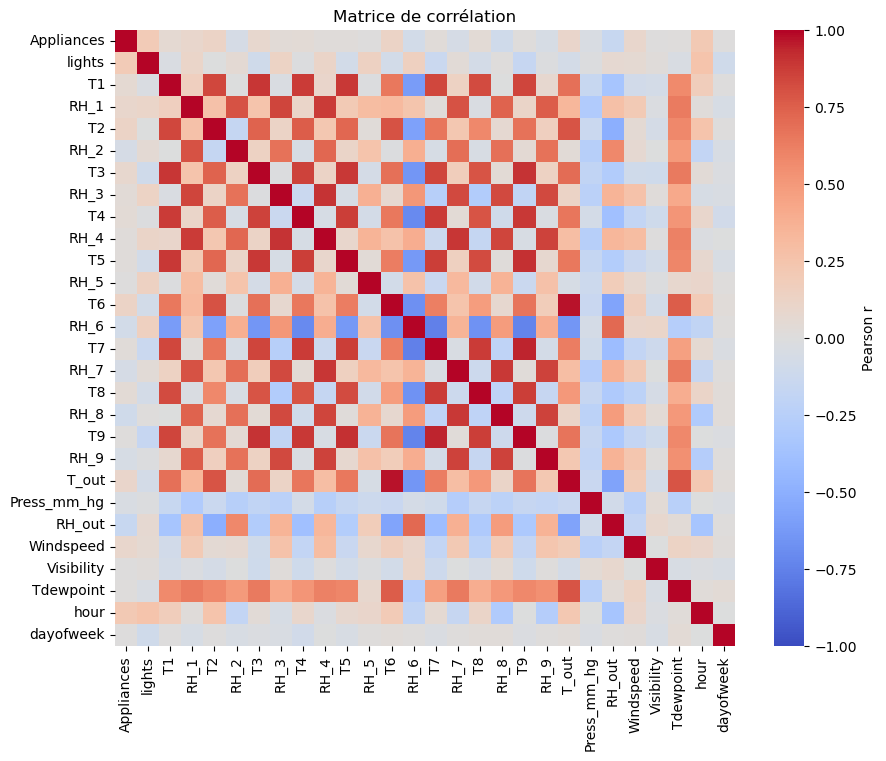

In [14]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            cbar_kws={'label':'Pearson r'})
plt.title("Matrice de corrélation")
plt.show()

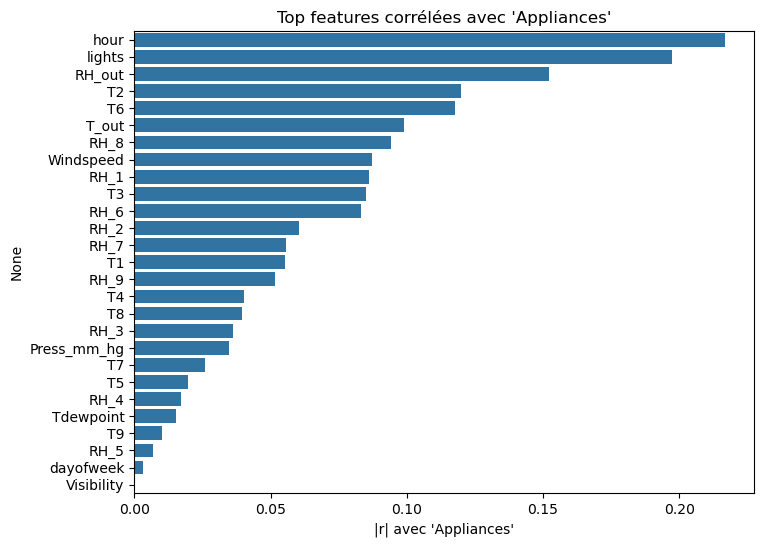

In [15]:
corr_target = df.corr()['Appliances'].abs().sort_values(ascending=False)[1:]
top_feats = corr_target.index

plt.figure(figsize=(8,6))
sns.barplot(y=top_feats, x=corr_target.values, orient='h')
plt.xlabel("|r| avec 'Appliances'")
plt.title("Top features corrélées avec 'Appliances'")
plt.show()

- Toutes les températures et humidités sont évidement extrêmement **corrélées** entre elles, il va donc falloir gérer cette **multicolinéarité** dans la modélisation.
- On remarque globalement peu de correlation avec la cible `Appliances`
- En revanche, `hour` est le facteur le plus corrélé avec `Appliances` (~22%) ce qui confirme l’importance de l’heure dans la consommation d’énergie.
- Aussi, `lights` et la température dans le salon `T2` ont une correlation de ~20% et 15% avec `Appliances`. Ils représentent de bons **indicateurs d'occupation** et donc de consommation d'énergie.
- l'humidité extérieur `RH_out` et les températures extérieurs `T_out` et `T6` sont aussi corrélée avec la cible (~15, ~12 et ~10% respectivement). 


> Pistes pour le feature engineering :  
>  - **ACP** ou **moyennes** pour réduire la multicolinéarité des variables de température et d’humidité.
>  - Créer un **indicateur d'occupation** à partir de `lights` et `T2`.

Dans la suite, nous allons implémenter différents modèles sous le schéma suivant : 
- Prétraitement des données (nettoyage, transformation, feature engineering) propre à chaque modèle
- Séparation des données en train et test
- Entraînement des modèles sur les données d’entraînement
- Évaluation des performances sur les données de test

puis nous ferons une analyse des résultats 

# 4. Modèles linéaires

## 4.1 Feature engineering

In [16]:
df.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'hour', 'dayofweek'],
      dtype='object')